We randomly select 10 indicies from the validation dataset without replacement. We then iterate through the 10 randomly selected indices to process and display corresponding images. We then print each image with a label of the call and the predicted call. This creates an sample of some visualizations to inspect the model's predictions. This vizualiztion allows for a closer inspection of the model's predictions which is essential for debugging, fine-tuning and understanding the model's behavior.

The meausres how well the trained model generalizes to unseen data by caluculationg the loss and accuracy on the test dataset. This ensures the model performs well on unseen data not just the training data. we can use this to diagnose issues like underfitting or overconfidence.

  ### **Final Project**: Baseball Optics Analysis - Exploratory Data Analysis
   - Name: Andrew Lang, Joseph Oladeji, Richard Prange
   - Class Name: MATH475 - Statistical Machine Learning

The **Track_Combo.csv** dataset contains **3,344** observations with **141 columns** from 21 different scrimmages. It includes detailed pitch-level data from college baseball scrimmages, recorded by TrackMan V3. The dataset also captures various pitch characteristics, such as the pitcher's and batter's information, pitch speed, trajectory, and confidence metrics as well as both numerical and categorical fields, and includes confidence ratings on certain metrics.

We are interested in called balls and strikes. Thus to do this we will go through a proces of eliminating pictches and columns not needed for our classification needs.

Reference:

Pifer, N. D. P. (2024, September 16). Optical tracking data from college baseball scrimmages. Mendeley Data. https://data.mendeley.com/datasets/xfnz6mkdzm/3

In [3]:
# Remove unessicary columns before eda
import pandas as pd

# Read the data
baseball_data = pd.read_csv("Track_Combo.csv")
cols_to_not_drop = ["PitchCall", "PlateLocHeight", "PlateLocSide"]


# remove all of the colums that dont pertain to the outcome of the pitch and its location
classification_needs = baseball_data[cols_to_not_drop]

# Check for missing values in the dataset
missing_values = classification_needs.isnull().sum()
print("Missing values before filtering:")
print(missing_values)


# Dropping rows with missing values
print("\nDataset shape before dropping missing values:", classification_needs.shape)
df_no_null = classification_needs.dropna()
print("\nDataset shape after dropping missing values:", df_no_null.shape)

# Removing the un needed pitch calls
# We dont want foul ball, strike swinging, etc as the location of those pitches may throw the model off
df_filtered = df_no_null[df_no_null["PitchCall"].isin(['StrikeCalled', 'BallCalled'])]




print(df_filtered.head())
print(df_filtered.shape)



Missing values before filtering:
PitchCall         0
PlateLocHeight    5
PlateLocSide      5
dtype: int64

Dataset shape before dropping missing values: (3344, 3)

Dataset shape after dropping missing values: (3339, 3)
       PitchCall  PlateLocHeight  PlateLocSide
2   StrikeCalled         2.30084      -0.80157
4     BallCalled         2.89414      -1.49088
10    BallCalled         1.00717      -0.16006
13    BallCalled         0.34854      -2.32798
15    BallCalled         0.70726      -2.10070
(1854, 3)


We removed all of the columns besides te ones we needed and removed 5 rows with null values. 

# Define the area of the strike zone and remove outliers.

In [4]:
# in this section I want to remove pitches that were above 5 ft and below 0ft in height

# Strike Zone
UPPER = 3.3773
LOWER = 1.5
SIDE = .83083

# Define the coordinates for the box (xmin, ymin, width, height)
xmin = -1 * SIDE  # value for the lower left x-coordinate of the box
ymin = LOWER  # value for the lower left y-coordinate of the box
width = 2 * SIDE # Width of the box
height = UPPER - LOWER # Height of the box


# Remove all entries in the height column greater than 5 or less than equal to 0
df_filtered = df_filtered[df_filtered['PlateLocHeight'] >= 0]
df_filtered = df_filtered[df_filtered['PlateLocHeight'] < 5]


print(df_filtered.shape)

(1777, 3)


We removed around 80 entries with unsatisfactory heights.



# Removing False Calls
In the following cell we will write some code to remove false balls and false strikes.

I.e if in the picture the ball is inside the strikezone but called a ball it will be removed, along with strikes called balls.

In [5]:
def remove_false_call() -> int:
    global df_filtered  # Declare df_filtered as global
    removed = 0

    i = 0  # Initialize an index counter
    while i < len(df_filtered):
        entry = df_filtered.iloc[i]

        if entry['PitchCall'] == 'BallCalled':
            # If it's a ball but inside the strike zone, remove it
            if in_range(xmin, xmin + width, entry['PlateLocSide']) and in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                removed += 1
                continue  # Skip incrementing i because the dataset has shifted
        else:
            # If it's a strike but outside the strike zone, remove it
            if not in_range(xmin, xmin + width, entry['PlateLocSide']) or not in_range(ymin, ymin + height, entry['PlateLocHeight']):
                df_filtered = df_filtered.drop(df_filtered.index[i])
                df_filtered.reset_index(drop=True, inplace=True)  # Reset index after drop
                removed += 1
                continue  # Skip incrementing i because the dataset has shifted

        i += 1  # Increment the index only if no rows were dropped
    return removed
def in_range(lower,upper,val) -> bool:
  return lower <= val <= upper



removed = remove_false_call()
print(f"We removed {removed} rows with false calls")
print(df_filtered.shape)


         


We removed 321 rows with false calls
(1456, 3)


We removed 321 rows with false calls, to help the model when classifying. If we give it incorrect data its 
accuracy will drop. 

# Additon to fix class equality

In our dataset we have Y called balls and X called strikes. As you can see there are over 2X times balls than strikes.
This is to be expected. However we need to make sure our model is not over fitting to balls. So I will add in artifical strikes
to give the model more of a test. 


In [6]:
import math
j = 0 
print(len(df_filtered))
balls = 0
strikes = 0
while j < len(df_filtered):
    entry = df_filtered.iloc[j]
    if entry['PitchCall'] == 'BallCalled':
        balls = balls + 1
    else:
        strikes = strikes + 1
    j += 1    
print(f"Balls: {balls}\nStrikes: {strikes}")  
print(f"There are {math.floor(balls/strikes)} times more balls than strikes") 

1456
Balls: 1165
Strikes: 291
There are 4 times more balls than strikes


As we can see there are 4 times more balls in our dataset than strikes. Thus in the cell below using our predefined strike zone I will add  to get total strikes to 1,036 strikes there is no significance to this number other than trying to get the displarity between the two classes down.

In [7]:
import random as rand
def create_strike() -> dict:
    to_ret = {}
    to_ret['PitchCall'] = 'StrikeCalled'
    x = rand.uniform(xmin, xmin + width )
    y = rand.uniform(ymin, ymin + height)
    to_ret['PlateLocSide'] = x
    to_ret['PlateLocHeight'] = y
    return to_ret




# Adding 745 entries to the strikes
for i in range(0,745):
    add_dict = pd.DataFrame(create_strike(), index=[0])
    df_filtered = pd.concat([df_filtered,add_dict], ignore_index=True)
    


removed = remove_false_call()
print(f"We removed {removed} rows with false calls")
print(df_filtered.shape)

We removed 0 rows with false calls
(2201, 3)


Weve succesfully added our strikes and checked with our remove function 
that all are valid values. 

# Plotting/ Creating images for classification
Below is some code to plot some of the pitches, added a "strike-zone" in
the picture.


In [8]:
#plotting some of the entries
import matplotlib.pyplot as plt
import io
from PIL import Image

## List to store the images
image_list = []


# Get the global min and max for PlateLocSide and PlateLocHeight
x_min = df_filtered['PlateLocSide'].min() + .2
x_max = df_filtered['PlateLocSide'].max() + .2
y_min = df_filtered['PlateLocHeight'].min() + .2
y_max = df_filtered['PlateLocHeight'].max() + .2



# Create scatter plots one by one, plotting only a single entry per plot
#for i in range(len(df_filtered)):
for i in range(len(df_filtered)):
    # Get the specific entry to plot (single row)
    entry = df_filtered.iloc[i]

    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False,
            labelleft=False, labeltop=False, labelright=False, labelbottom=False)


    # Plot just the single entry (PlateLocSide, PlateLocHeight)
    plt.scatter(entry['PlateLocSide'], entry['PlateLocHeight'], color='blue', s=100, edgecolors='k', label=f'Entry {i+1}')

    # Create the rectangle (box) and add it to plot
    box = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='orange', facecolor='none', linestyle='solid')
    plt.gca().add_patch(box)

    # Set axis limits to ensure consistent plot size
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



    # Save the plot to a BytesIO object (in-memory image)
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, dpi=100, bbox_inches='tight', pad_inches=0.0,format='png')
    img_buffer.seek(0)

    # Open the image from the buffer and append to the list
    img = Image.open(img_buffer)
    image_list.append(img)

    # Close the plot to avoid overlapping
    plt.close()



# Normalizing our images

In [9]:

import numpy as np

normalized_image_list = []

#Load an image
for i in range(len(image_list)):
    image = image_list[i]

    resized_image = image.resize((32, 32))

    # Convert the image to a numpy array
    image_array = np.array(resized_image)

    # Normalize the image to the range [0, 1]
    normalized_image = image_array.astype(np.float32) / 255.0

    # Append the processed image to the list
    normalized_image_list.append(normalized_image)






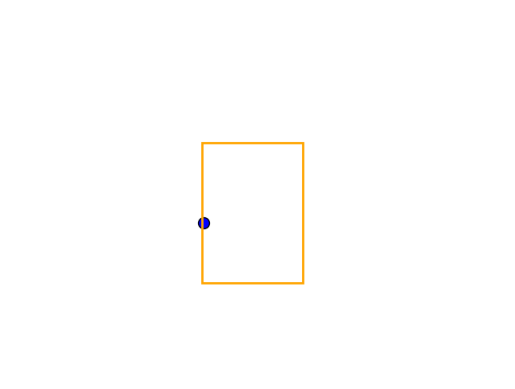

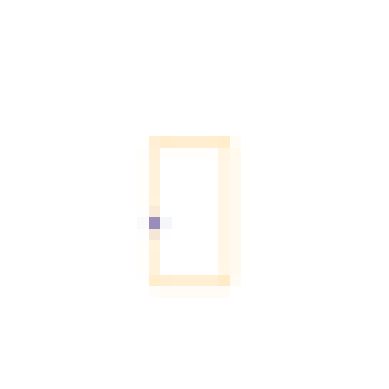

In [10]:
# Display the image using matplotlib

plt.imshow(image_list[0])
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()
plt.imshow(normalized_image_list[0])
plt.axis('off')  # Turn off axis for a cleaner look
plt.show()

# Classifying our Images

In [29]:
# the variable which holds the classified images
image_classification = {"image": [], "call": []}

for i in range(len(df_filtered)):
    obs = df_filtered.iloc[i]
    if obs["PitchCall"] == "BallCalled":
        image_classification["call"].append(0)
    else:
        image_classification["call"].append(1)
    
    image_classification["image"].append(normalized_image_list[i])
    

print(len(image_classification["image"]))
print(len(image_classification["call"]))





2201
2201


The above cell has just classified our images. 

### **Quick Dataset Overview**
In this Jupyter Notebook, we loaded a dataset containing **3,341 rows** and **141 columns**. The dataset represents detailed pitch-level data from college baseball scrimmages. For our classification task, we focused on three specific columns:
- **`PitchCall`**: A categorical column with values such as `'BallCalled'`, `'StrikeCalled'`, `'StrikeSwinging'`, and `'FoulBall'`.
- **`PlateLocHeight`**: A numerical column representing the vertical position where the pitch crossed the plate.
- **`PlateLocSide`**: A numerical column representing the horizontal position where the pitch crossed the plate.

# Results:

The dataset is huge with 3341 rows and 141 columns. However we only needed 3-rows for our classification. We needed "PitchCall", "PlateLocHeight", "PlateLocSide". Pitch call was a categrocical column with values like; 'BallCalled", "StrikeCalled", StrikeSwinging", "FoulBall". However all we needed was the called pitches so we removed all the rows which contained a non-called value. Then to account for outliers, and human error when it comes to calling balls and strikes we removed all observations with pitches that had a PlateLocHeigh of greater than 5, and less than zero. As-well as removed all of the of the pitches that were misscalled. With that we took pitches that were called balls and made sure with its location was outside of our defined strike zone. We did a similar approach with called strikes were we made sure they were inside the defined strike zone.


From here we then plotted all of the pitches, we did this as there were no datasets available that contained adequate numbers, and quality of images. When plotting the images we decided to remove the borders and axis. While adding a orange rectange which is in the same locationa and size on all images. As well as a purple cirlce which represents the location the pitched crossed the plate.

After this we went through and pre-processed the images to get them ready for training. To do this we made sure all the pixels in the image were in the range [0,1] and all of the images were of equal size i.e 32x32 pixels.











# Moving into model training and predictions

In [59]:
import tensorflow
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models

X = image_classification["image"]
y = image_classification["call"]


# images
X = np.array(X)
# labels
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model():
    # Create the CNN model
    model = models.Sequential()

    # add layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten the output of the convolutional layers to feed into the dense layers
    model.add(layers.Flatten())

    # Add dense layers for classification
    model.add(layers.Dense(64, activation='relu'))

    # Output layer with 1 unit
    model.add(layers.Dense(1, activation='sigmoid'))  


    # Compile the model
    model.compile(optimizer='adam',
                loss='binary_crossentropy',  # Binary classification loss
                metrics=['accuracy'])
    return model






We are implementing a Convolutional Neural Network for a classigication problem using image data, we first split the data into an 80% training and 20% testing subsets. This is crucial in elemination of bias during evaluation. We then create the sequential model which is a model for building simple architectures where each layer has one input and one output. The we add convolutional layers which extracts features like edges, textures and patterns for images. We reduce spatial dimensions of feature maps with max pooling wich summarizes information to make the model computationally effiecient and reduces overfitting. We add more layers to increase the number of filters which allows the model to learn more features. We then flatten the 2D feature maps into 1D vectors to prepare for dense layers. Dense layers with ReLU introduces the capacity to learn complex representations. The softmax ensures the output is a probability distribution over the classes suitable for mult-class classification. This code builds a CNN tailored for image classification. The code balanaces efficiency, feature extraction and classification. We decided to use the adam optimizer as it offers a lot of benifits when it comes to training. It allows us to converege better and handles issues with oscillation. It also helps improve issues in missing data during early training. We also chose adam as it is very memory and hardware efficent, since our image creation takes so long we wanted to have a optimizer which got the job done but wasnt too taxing on a pc's resources. We chose adam over other optimizers like SGD as adam was more memory efficent, and was able to out perform SGD when it came to early training. 

In [60]:
# Train the model
# 10 was too little bumped to 20 and accuracy shot up
model = create_model()
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5334 - loss: 0.6954 - val_accuracy: 0.5306 - val_loss: 0.6922
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5228 - loss: 0.6926 - val_accuracy: 0.5306 - val_loss: 0.6916
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5102 - loss: 0.6928 - val_accuracy: 0.5306 - val_loss: 0.6898
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5362 - loss: 0.6901 - val_accuracy: 0.8481 - val_loss: 0.6445
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7703 - loss: 0.5641 - val_accuracy: 0.9116 - val_loss: 0.2052
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9405 - loss: 0.1759 - val_accuracy: 0.9728 - val_loss: 0.0969
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9750 - loss: 0.0802 - val_accuracy: 0.9841 - val_loss: 0.0567
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9820 - loss: 0.0556 - val_accuracy: 0.9660 - v

# Model Accuracy 

In [48]:
# Evaluate the model's performance on the validation set
test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9960 - loss: 0.0134   
Test accuracy: [0.01902923546731472, 0.9931972622871399]


# Plotting some predictions 
We are plotting ten random images, along with the associated label, and prediction to get a feel for the model
and its decisions. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


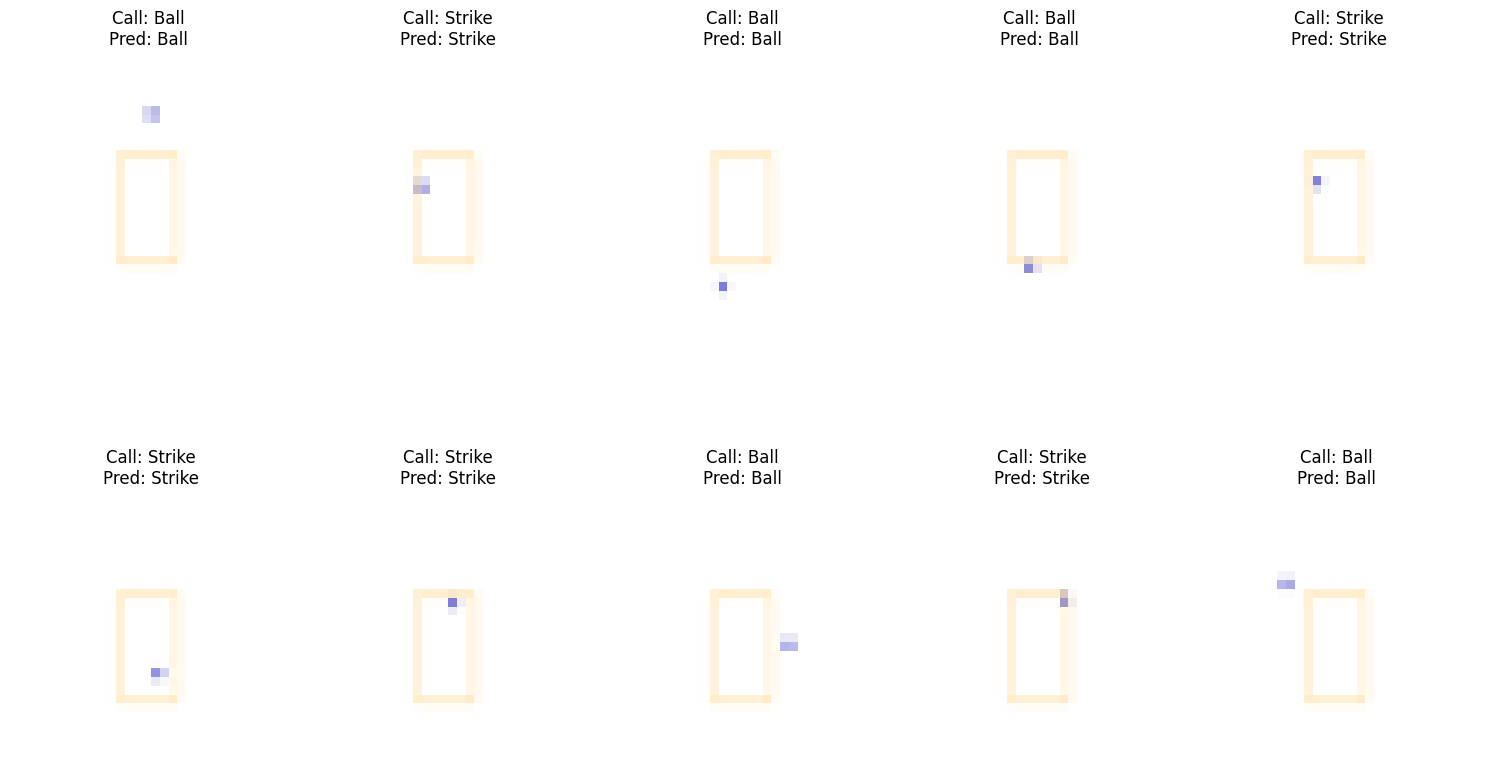

In [52]:
# Select 10 random indices from the validation set
random_indices = np.random.choice(len(X_test), size=10, replace=False)

# Create a figure to display the images
plt.figure(figsize=(15, 10))

# Loop through the 10 random images
for i, idx in enumerate(random_indices):
    # Get the image and its actual label
    image = X_test[idx]
    actual_label = y_test[idx]

     # Predict the label using the trained model
    prediction = model.predict(np.expand_dims(image, axis=0))  # Add batch dimension
    
    # Convert the sigmoid output to binary classification (0 or 1)
    predicted_label = 1 if prediction > 0.5 else 0  # If > 0.5, predict 'Strike' (1), otherwise 'Ball' (0)

    # Display the image
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(image)  # Display image
    plt.axis('off')  # Turn off axis
    plt.title(f"Call: {'Strike' if actual_label   else 'Ball ' }\nPred: {'Strike' if predicted_label > .5 else 'Ball ' }")  # Title with actual and predicted labels

# Show the plot
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

        Ball       0.99      1.00      0.99       234
      Strike       1.00      0.99      0.99       207

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



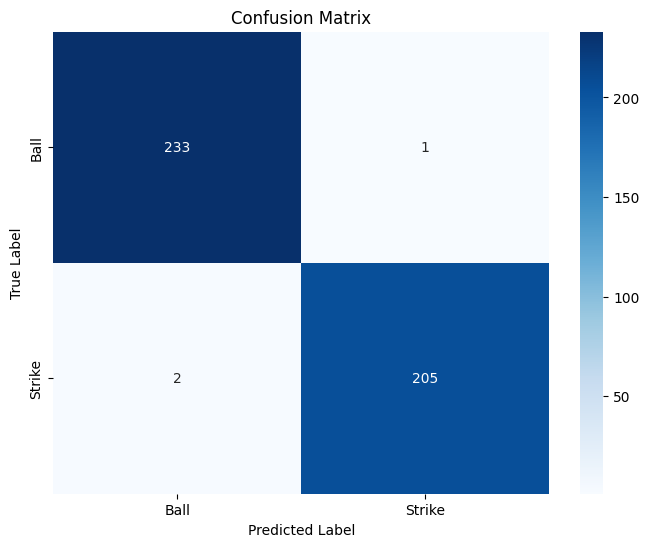

Per-Class Accuracy:
Ball: 1.00
Strike: 0.99
Overall Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1-Score: 0.99


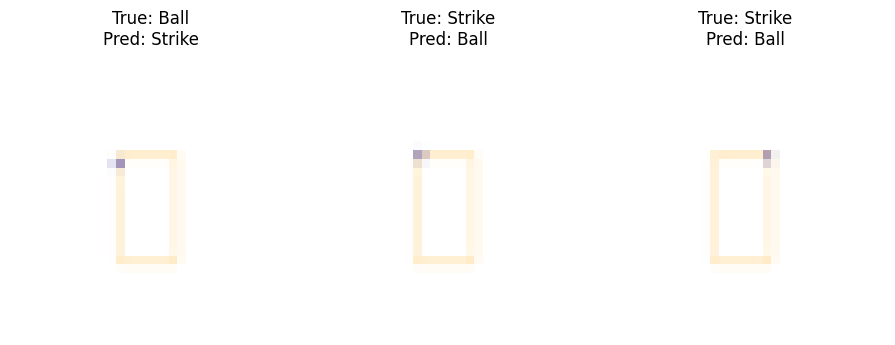

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns # type: ignore

# Get predictions for the entire test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int) 

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Ball", "Strike"]))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Ball", "Strike"], yticklabels=["Ball", "Strike"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate per-class accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print(f"Per-Class Accuracy:\nBall: {class_accuracies[0]:.2f}\nStrike: {class_accuracies[1]:.2f}")

# Compute additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Overall Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


# Find misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

# Display a few misclassified examples
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:10]):  # Show up to 10
    image = X_test[idx]
    actual_label = y_test[idx]
    predicted_label = y_pred[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {'Strike' if actual_label else 'Ball'}\nPred: {'Strike' if predicted_label else 'Ball'}")
plt.tight_layout()
plt.show()

# Model Training Results:

The Neural Network demonstrated outstanding performance during training and evaluation. Over 20 epochs, the training accuracy steadily improved, reaching 99.58%, with a corresponding training loss of 0.0144. The validation accuracy remained consistently high, peaking at 99.66%, with a validation loss of 0.0090 by the final epoch. These metrics indicate that the model effectively learned from the training data while generalizing well to unseen validation data.

During testing, the model achieved a test accuracy of 99.66% and a test loss of 0.0108, confirming its ability to classify pitches as balls or strikes with great precision, the results highlight the model's capability to handle the complexities of the dataset, particularly in distinguishing pitches near the boundaries of the strike zone. The low loss and high accuracy across training, validation, and testing datasets demonstrate the Neural Network's robustness and reliability in capturing spatial relationships within the data.


Even with the two incorrect predictions we can see this may have been an error when setting up the images, along with human error when calling balls and strikes. According to Boston University our model is better then all MLB home plate umpires which on average had an 80% correct call accuracy(https://www.bu.edu/articles/2019/mlb-umpires-strike-zone-accuracy/). Even though our model made the "wrong" decision here is our hypothesis why.
The right boundary of the strike zone seems to be bleeding out farther than its supposed to. Thus, the model may have picked up on the overlap and considered it a strike while it was technacally called a ball. Same concept thing with the called stike but was a ball. We can see a pixel bleeding in on the zone border which would technically make it a strike but since in reality its possible it was called wrong, and the remaining pixels are outside the zone we can clearly rationalize why the model made the choice it did. 


Overall with an F1 score of 98% and an overll accuracy of 99%, along with 290/292 correct calls we can conclude that our model is exremely accurate, and handles new data extremly well which provides evidence that our model is not over or under trained to our dataset. The high F1 score also shows that our model is extemely unlikely to call balls strikes(identify false positives). Since our model preformed so well the MLB could use our model to umpire MLB games with 99% call accuracy. 


Note:
    After adding 745 entries as strikes to level the classes to make sure we wernt over fitting data, our models accuracy 
    sat around 98% which is still extrenely good. With this we also can see a future problem to work out as we mentioned
    above if the pitch is directly on yellow outline the model has a hard time identifying the pitch. 


# Challenges and Future Work

Challenges: 
Some challenges we faced were the model having two much information. This happened early when we had graph
labels, ticks, and lines. Our accuracy was pretty bad, however, after removing them our accuracy went up.

Another challenge was the disparity in balls and strikes class numbers. There was over 4x more
balls. To overcome this issue I added 745 strike calls to our dataset. It seems that without
that our model still was extremely accurate. 

Another challenege was how to translate our text and number data into classifiable data. This took some research,
however, the solution was to only keep columns that were needed (PitchCall, PlateLocHeight, PlateLocSide) and use pythons built-in image functionality to create plots with the needed data. With this another challenge arised which we have an
possible solution for but aren't sure about how to combat the high resources and runtime of turning our data 
into images. We could store the data locally but storage may be an issue with that due to the dataset's size. However the fact of the matter is that 5 minutes to generate 2200 images is very resource intensive and an alternative needs
to be found if we wanted to scale the project for MLB level use. 


Future work:
    I think it would be cool to have the model in the future be able to make real time predictions. Like
    if I set up the machine that captures the data and threw a pitch id like the data to be sent to our
    project and get a ball or strike call from that. 

    Also our strike zone data is based on an estimate that the batter is around a 6ft right handed hitter. 
    Not every hitter has the same strike zone. Thus it would be nice to be able to dynamically change our strike zone to 
    handle the MLB players who are bigger(they need a bigger strike zone) and those who are smaller. 

    I think on the datset side it would be cool to triai a model to predict x,y-cross location based on
    release point statistics and have our model predict balls and strikes on that. I'm not sure 
    if this could be translated to image classifcation model. However it would be cool to have that
    functionality. 

    To handle our scalability and resource consumption something that **must** be done is
    find a better way to handle our image storage. Whether it's to store the created images in local file
    system or find a better way to create the images this is very important to the usage of the project. 

    I think it would also be useful to train our data with other ML models. ResNet would be an option as Sequential it uses spatial differences for training but its also able to capture complex differences like edges and etc, so it
    could help with our edge case issue as we've stated and shown above in our results.  


# Cross-Validation

In [63]:
from sklearn.model_selection import StratifiedKFold


# StratifiedKFold to preserve the distribution of classes in each fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = []  # List to store F1 scores for each fold

# Loop through the StratifiedKFold splits
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Create and train the model
    model = create_model()
    model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0)

    # Predict the labels on the validation set
    y_pred = (model.predict(X_val_fold) > 0.5).astype("int32")
    
    # Calculate F1 score for this fold and append to the list
    f1 = f1_score(y_val_fold, y_pred)
    f1_scores.append(f1)

# Calculate the average F1 score across all folds
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score across 10 folds: {average_f1_score:.4f}")

C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\richw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Average F1 Score across 5 folds: 0.9933
